In [1]:
from run_sim import run_sim
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
# set up dataframe for collecting event data
mtd_stats, attack_stats = run_sim()

Target Node is:  73


In [3]:
print(mtd_stats.dict())
mtd_operation_record = pd.DataFrame(mtd_stats.mtd_operation_record)

mtd_operation_record

{'Total suspended MTD': 142, 'Total triggered MTD': 487, 'Total executed MTD': 344, 'Total attack interrupted': 250}


,name,start_time,finish_time,duration
0,IPShuffle,30.419217,80.549802,50.130584
1,IPShuffle,91.411215,142.388632,50.977418
2,osdiversity,122.438367,152.545612,30.107245
3,CompleteTopologyShuffle,152.793486,224.840656,72.047170
4,IPShuffle,244.469806,295.024962,50.555157
...,...,...,...,...
339,UserShuffle,14608.507150,14618.566190,10.059040
340,serviceDiversity,14638.995426,14679.048642,40.053216
341,serviceDiversity,14699.176727,14740.813739,41.637012
342,HostTopologyShuffle,14729.723379,14770.253547,40.530168


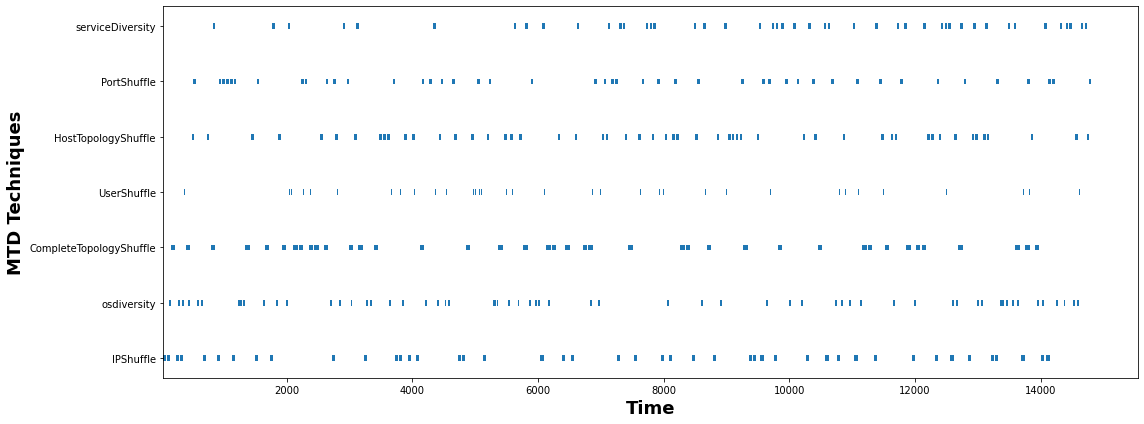

In [4]:
fig, ax = plt.subplots(1, figsize=(16, 6))
ax.barh(mtd_operation_record['name'], mtd_operation_record['duration'], left=mtd_operation_record['start_time'], height=0.1)

plt.xlabel('Time',  weight='bold', fontsize=18)
plt.ylabel('MTD Techniques', weight='bold', fontsize=18)
fig.tight_layout()
plt.show()

In [5]:
attack_operation_record = pd.DataFrame(attack_stats.attack_operation_record)
attack_operation_record

,name,start_time,finish_time,duration,current_host,current_host_attempt,cumulative_attempts,cumulative_compromised_hosts,compromise_host,compromise_users,interrupted_in,interrupted_by
0,SCAN_HOST,0.000000,5.000000,5.000000,-1,0,0,0,,[],,
1,ENUM_HOST,5.000000,7.000000,2.000000,-1,0,0,0,,[],,
2,SCAN_PORT,7.000000,17.000000,10.000000,0,1,0,0,,[],,
3,EXPLOIT_VULN,17.000000,47.576702,30.576702,0,1,0,0,,[],,
4,BRUTE_FORCE,47.576702,67.576702,20.000000,0,1,17,0,,[],,
...,...,...,...,...,...,...,...,...,...,...,...,...
1908,SCAN_PORT,14803.431932,14813.431932,10.000000,19,4,910,199,,[],,
1909,EXPLOIT_VULN,14813.431932,14843.784312,30.352380,19,4,910,199,19,[],,
1910,SCAN_NEIGHBOR,14843.784312,14848.784312,5.000000,19,4,910,200,,[],,
1911,ENUM_HOST,14848.784312,14850.784312,2.000000,19,4,910,200,,[],,


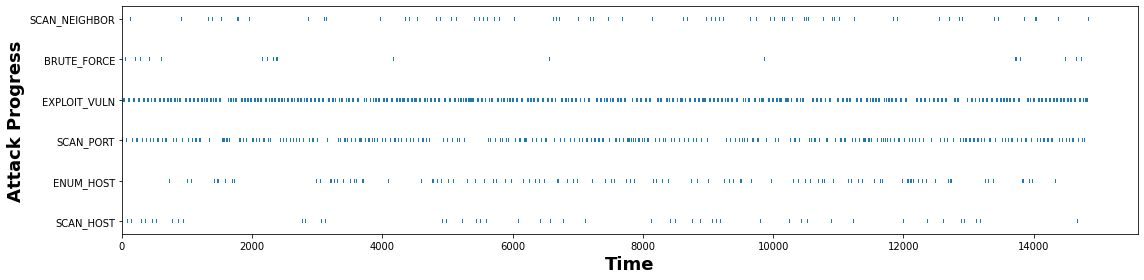

In [6]:
fig2, ax2 = plt.subplots(1, figsize=(16, 4))
ax2.barh(attack_operation_record['name'], attack_operation_record['duration'], left=attack_operation_record['start_time'], height=0.1)

plt.xlabel('Time',  weight='bold', fontsize=18)
plt.ylabel('Attack Progress', weight='bold', fontsize=18)
fig2.tight_layout()
plt.show()

In [7]:
attack_operation_record[(attack_operation_record['name'] == 'SCAN_PORT') & (attack_operation_record['compromise_host'] != '')]

,name,start_time,finish_time,duration,current_host,current_host_attempt,cumulative_attempts,cumulative_compromised_hosts,compromise_host,compromise_users,interrupted_in,interrupted_by
155,SCAN_PORT,1555.448744,1565.448744,10.0,22,1,404,14,22,"[Letty, Carma, Clerissa]",,
159,SCAN_PORT,1574.448744,1584.448744,10.0,37,5,404,15,37,"[Lenette, Aloysia]",,
165,SCAN_PORT,1597.448744,1607.448744,10.0,58,1,404,16,58,"[Shalne, Laurene, Margarethe, Ilse]",,
183,SCAN_PORT,1777.532679,1787.532679,10.0,53,2,423,19,53,"[Risa, Whitney, Babara]",,
322,SCAN_PORT,3128.778242,3138.778242,10.0,49,1,541,32,49,[Daryl],,
347,SCAN_PORT,3295.173683,3305.173683,10.0,41,3,560,35,41,"[Irita, Carolina]",,
362,SCAN_PORT,3410.071263,3420.071263,10.0,52,3,560,37,52,[Sally],,
385,SCAN_PORT,3584.875374,3594.875374,10.0,28,8,567,40,28,"[Sherri, Catharina]",,
395,SCAN_PORT,3660.716505,3670.716505,10.0,65,1,567,41,65,[Sibylla],,
398,SCAN_PORT,3677.716505,3687.716505,10.0,88,1,567,42,88,"[Marieann, Johnath, Mandi]",,


In [8]:
attack_operation_record[(attack_operation_record['name'] == 'EXPLOIT_VULN') & (attack_operation_record['compromise_host'] != '')]

,name,start_time,finish_time,duration,current_host,current_host_attempt,cumulative_attempts,cumulative_compromised_hosts,compromise_host,compromise_users,interrupted_in,interrupted_by
11,EXPLOIT_VULN,99.549802,130.339802,30.790000,0,2,17,0,0,"[Keriann, Kaila, Kaycee, Kassandra, Fanechka]",,
57,EXPLOIT_VULN,623.531567,653.532283,30.000716,55,2,123,1,55,"[Valeria, Kristel, Blinny]",,
63,EXPLOIT_VULN,685.209657,715.887285,30.677628,52,1,129,2,52,"[Gypsy, Emilee, Irena, Selene, Angelle]",,
70,EXPLOIT_VULN,741.924933,772.184352,30.259419,41,1,152,3,41,"[Annemarie, Arabella, Zonda, Mareah]",,
75,EXPLOIT_VULN,791.959605,824.571981,32.612376,21,1,202,4,21,"[Bernadine, Caye, Gisella]",,
...,...,...,...,...,...,...,...,...,...,...,...,...
1853,EXPLOIT_VULN,14169.746139,14200.399255,30.653115,14,2,895,194,14,[],,
1859,EXPLOIT_VULN,14230.704780,14261.026100,30.321320,15,1,908,195,15,[],,
1868,EXPLOIT_VULN,14299.026100,14329.603366,30.577266,17,1,908,197,17,[],,
1874,EXPLOIT_VULN,14352.725215,14382.747219,30.022005,18,1,910,198,18,[],,


In [9]:
attack_operation_record[(attack_operation_record['name'] == 'BRUTE_FORCE') & (attack_operation_record['compromise_host'] != '')]

,name,start_time,finish_time,duration,current_host,current_host_attempt,cumulative_attempts,cumulative_compromised_hosts,compromise_host,compromise_users,interrupted_in,interrupted_by


In [10]:
if not os.path.exists('data_analysis'):
    os.makedirs(os.path.dirname('data_analysis'))

attack_operation_record.to_csv('data_analysis/attack_operation_record.csv',index=False)
mtd_operation_record.to_csv('data_analysis/mtd_operation_record.csv', index=False)